# Recurrent Neural Network
## 1. RNN using `nn.RNNCell`
...

## Implementation
This implementation of RNN using `nn.RNNCell`

**Dimensions** 
- `b` : batch size
- `s` : input sequence length
- `d` : RNN layer depth(num_layer)
- `h` : hidden vector size
- `v` : vocabulary size
### imports

In [12]:
#%%
import torch
from torch import nn, optim

### Model
input|<span style="font-weight:normal">- Sequence Data `(torch.tensor: (b, s, v))`<br />- hidden state `(torch.tensor: (d, b, h))`</span>
|:-------:|:---------------------------------------------------------------------------------|
**output**| (Output Sequence, hidden state) `(Tuple[torch.tensor]: ((b, s, h), (d, b, h)))`

: `RNN` implements Recurrent Neural Networks with pytorch's `nn.RNNCell`.

![](asset/track.PNG)

In [13]:
class RNN(nn.Module):
    def __init__(self,input_size, hidden_size, num_layers):
        super(RNN, self).__init__()
        self.rnncells = [nn.RNNCell(hidden_size if i else input_size, hidden_size) for i in range(num_layers)]
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, xs, h):
        xn, h = [], list(h)
        for m, x in enumerate(xs):
            for n, (hl, cell) in enumerate(zip(h, self.rnncells)):
                h[n] = x = cell(x, hl)
            xn.append(h[-1])
        return torch.stack(xn), torch.stack(h)

#### Test model

In [14]:
torch.manual_seed(0)
input_size, hidden_size, num_layers = 3, 4, 2
batch_size = 2
seq_len = 3

rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
myrnn = RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)

x = torch.ones((seq_len, batch_size, input_size))
h = torch.zeros((num_layers, batch_size, hidden_size))

rnn_out, rnn_h_next = rnn(x, h)
myrnn_out, myrnn_h_next = myrnn(x, h)

print(f'{rnn_out.shape=}\n{rnn_out=}')
print(f"{myrnn_out.shape=}\n{myrnn_out=}")

rnn_out.shape=torch.Size([3, 2, 4])
rnn_out=tensor([[[0.3235, 0.8002, 0.3346, 0.2691],
         [0.3235, 0.8002, 0.3346, 0.2691]],

        [[0.2259, 0.5675, 0.2720, 0.1395],
         [0.2259, 0.5675, 0.2720, 0.1395]],

        [[0.2359, 0.6906, 0.1799, 0.0532],
         [0.2359, 0.6906, 0.1799, 0.0532]]], grad_fn=<StackBackward0>)
myrnn_out.shape=torch.Size([3, 2, 4])
myrnn_out=tensor([[[-0.5453, -0.5627, -0.2347,  0.1454],
         [-0.5453, -0.5627, -0.2347,  0.1454]],

        [[-0.0454, -0.4844, -0.2785, -0.3448],
         [-0.0454, -0.4844, -0.2785, -0.3448]],

        [[-0.2108, -0.5938, -0.4212, -0.0748],
         [-0.2108, -0.5938, -0.4212, -0.0748]]], grad_fn=<StackBackward0>)


## 2. RNN Exercise
...

## Exercise
Train `nn.RNN` so it predicts a sentence `'deep learning programming'`

### imports

In [31]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

### Data

In [32]:
cstr = "deep learning programming"

num2char = sorted(set(cstr))
char2num = {w:n for n, w in enumerate(num2char)}

t_batch = torch.tensor([char2num[c] for c in cstr])
x_batch = F.one_hot(t_batch, len(num2char)).float()

x = x_batch[:-1]
t = t_batch[1:]

### Model
input|<span style="font-weight:normal">- Sentence Sequence Data `(torch.tensor: (s, b, v))`<br />- hidden state `(torch.tensor: (d, b, h))`</span>
|:-------:|:---------------------------------------------------------------------------------|
**output**| Predicted one-hot Sequence `(torch.tensor: (s, b, v))`

: `CharRNN` uses `nn.RNN` and Dense layer to predict alphabet characters in one-hot.

In [33]:
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, output_size),
            nn.LogSoftmax()
        )

    def forward(self, x, h=None):
        if h is None:
            h = torch.zeros(1, self.hidden_size)
        out, hn = self.rnn(x, h)
        y = self.fc(out)
        return y

#### Declare Model

In [34]:
input_size, hidden_size = len(chars), 10
rnn = CharRNN(input_size, hidden_size, input_size)

### Training
#### Train setup

In [35]:
optimizer = optim.Adam(rnn.parameters(), lr=0.01)
lossfn = nn.NLLLoss()

#### Training loop

In [36]:
rnn.train()
losses = []
for epoch in trange(1000):
    y = rnn(x)
    L = lossfn(y, t)
    
    optimizer.zero_grad()
    L.backward()
    optimizer.step()

    losses.append(L.item())

  0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\PC\anaconda3\envs\diffuser\lib\site-packages\torch\nn\modules\container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 1000/1000 [00:01<00:00, 857.07it/s]


#### Loss curve

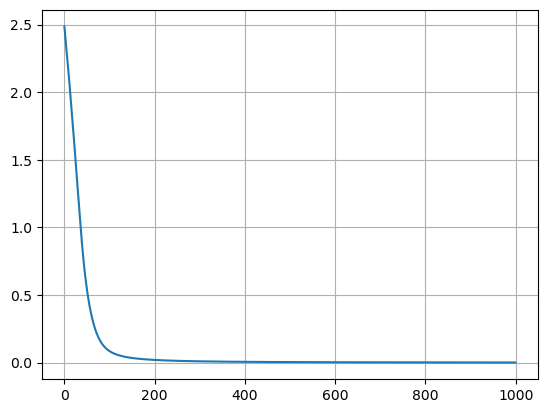

In [37]:
plt.grid()
plt.plot(losses)

#### Sentence Prediction Test

In [38]:
rnn.eval()
y = rnn(x).detach()
print("    input: ", '|'.join(cstr[:-1]))
print("predicted: ", '|'.join([num2char[c.item()] for c in torch.argmax(y, dim=1)]))

    input:  d|e|e|p| |l|e|a|r|n|i|n|g| |p|r|o|g|r|a|m|m|i|n
predicted:  e|e|p| |l|e|a|r|n|i|n|g| |p|r|o|g|r|a|m|m|i|n|g
